# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os
import torch
import requests, zipfile, io
import numpy as np
import matplotlib.pyplot as plt

from unityagents import UnityEnvironment
from collections import deque
from torchviz import make_dot, make_dot_from_trace
from ddpg_agent import Agent
from hyperparameters import *

%matplotlib inline

Download the Unity environment depending on your operating system.

In [2]:
## Choose your operating system:
#      mac
#      windows_x86
#      windows_x86_64
#      linux_x86
#      linux_x86_64
os_name = "windows_x86_64"

os_env_dict = {
    "mac": ["https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis.app.zip", "Tennis.app"],
    "windows_x86": ["https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86.zip", "Tennis_Windows_x86/Tennis.exe"],
    "windows_x86_64": ["https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86_64.zip", "Tennis_Windows_x86_64/Tennis.exe"],
    "linux_x86": ["https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux.zip", "Tennis_Linux/Tennis.x86"],
    "linux_x86_64": ["https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux.zip", "Tennis_Linux/Tennis.x86_64"]
}

def download_environment(os_name):
    environment_path = os_env_dict[os_name][1]
    if not os.access(environment_path, os.F_OK):
        url = os_env_dict[os_name][0]
        file = url.split('/')[-1]
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()    
    return environment_path

environment_path = download_environment(os_name)
print("Environment: {}".format(environment_path))

# output folder for trained model weigths
MODEL_DIR = 'model'
os.makedirs(MODEL_DIR, exist_ok=True)

# output folder for network architecture images
os.makedirs("resources", exist_ok=True)

Environment: Tennis_Windows_x86_64/Tennis.exe


Start the environment

In [3]:
env = UnityEnvironment(file_name=environment_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


Create DDPG agents for the two players

In [6]:
agent_1 = Agent(state_size=state_size, action_size=action_size, random_seed=10)
agent_2 = Agent(state_size=state_size, action_size=action_size, random_seed=10)

### Training

In [7]:
TARGET_SCORE = 1.0  # sloved score is 0.5

print_every = 100
episode_scores = deque(maxlen=print_every)
scores = []
avg_scores = []
best_avg_score = 0

for i_episode in range(1, EPISODES+1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the unity environment    
    states = env_info.vector_observations              # get initial state

    # reset the agents
    agent_1.reset()
    agent_2.reset()

    agent_scores = np.zeros(num_agents) # moving average over 100 episodes and over all agents

    while True:
        # determine actions from current state, using noise for exploration
        actions_1 = agent_1.act(states[0], add_noise=True)
        actions_2 = agent_2.act(states[1], add_noise=True)

        # send the actions to the environment
        actions = np.concatenate((actions_1, actions_2), axis=0)
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]

        next_states = env_info.vector_observations  # get the next states
        rewards = env_info.rewards                  # get the rewards
        dones = env_info.local_done                 # see if episode has finished

        # Send (S, A, R, S') info to the training agents for replay buffer (memory) and network updates
        agent_1.step(states[0], actions_1, rewards[0], next_states[0], dones[0])
        agent_2.step(states[1], actions_2, rewards[1], next_states[1], dones[1])

        states = next_states
        agent_scores += rewards
        if np.any(dones):
            break

    # calculate and print results
    episode_score = np.mean(agent_scores)    
    episode_scores.append(episode_score)
    scores.append(episode_score)
    average_score = np.mean(episode_scores)
    avg_scores.append(average_score)

    print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}\tBest Score: {:.2f}'
          .format(i_episode, episode_score, average_score, best_avg_score), end='')
 
    if i_episode % print_every == 0:
        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}\tBest Score: {:.2f}'
              .format(i_episode, episode_score, average_score, best_avg_score))
            
    if average_score > best_avg_score:
        best_avg_score = average_score
        # Save trained weights for both agents if average_score is better than the best_avg_score
        agent_1.save(MODEL_DIR, 1)
        agent_2.save(MODEL_DIR, 2)

    # stop training if target score is reached
    if average_score >= TARGET_SCORE:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))
        break


Episode 100	Max Score: -0.00	Average Score: -0.00	Best Score: 0.01
Episode 200	Max Score: -0.00	Average Score: -0.00	Best Score: 0.01
Episode 300	Max Score: -0.00	Average Score: 0.00	Best Score: 0.011
Episode 400	Max Score: 0.05	Average Score: 0.01	Best Score: 0.011
Episode 500	Max Score: -0.00	Average Score: 0.01	Best Score: 0.02
Episode 600	Max Score: 0.05	Average Score: 0.02	Best Score: 0.022
Episode 700	Max Score: -0.00	Average Score: 0.02	Best Score: 0.03
Episode 800	Max Score: -0.00	Average Score: 0.01	Best Score: 0.03
Episode 900	Max Score: -0.00	Average Score: 0.01	Best Score: 0.03
Episode 1000	Max Score: -0.00	Average Score: 0.02	Best Score: 0.03
Episode 1100	Max Score: 0.05	Average Score: 0.02	Best Score: 0.033
Episode 1200	Max Score: 0.05	Average Score: 0.03	Best Score: 0.033
Episode 1300	Max Score: 0.15	Average Score: 0.03	Best Score: 0.044
Episode 1400	Max Score: 0.05	Average Score: 0.05	Best Score: 0.055
Episode 1500	Max Score: 0.20	Average Score: 0.05	Best Score: 0.066
E

Plot the training scores

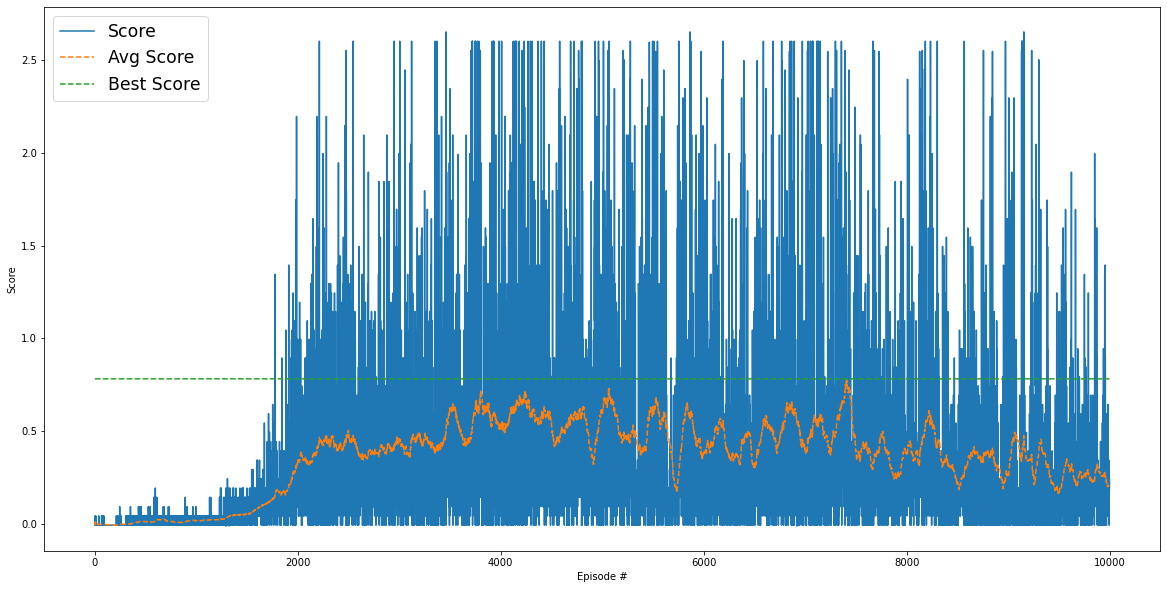

In [20]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(avg_scores)), avg_scores, linestyle='--')
plt.plot(np.arange(len(scores)), np.ones(len(scores)) * best_avg_score, linestyle='--')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(('Score', 'Avg Score', 'Best Score'), fontsize='xx-large')
plt.show()

### Test

In [9]:
agent_1.load(MODEL_DIR, 1)
agent_2.load(MODEL_DIR, 2)

Play 100 episodes

In [11]:
num_episodes = 100

scores = []

for i_episode in range(1, num_episodes + 1):

    # reset the unity environment 
    env_info = env.reset(train_mode=False)[brain_name]

    # get initial state of the unity environment 
    states = env_info.vector_observations

    # reset the agents
    agent_1.reset()
    agent_2.reset()

    agent_scores = np.zeros(num_agents) # moving average over 100 episodes and over all agents

    while True:
        # determine actions from current state
        actions_1 = agent_1.act(states[0], add_noise=False)
        actions_2 = agent_2.act(states[1], add_noise=False)

        # send the actions to the environment
        actions = np.concatenate((actions_1, actions_2), axis=0)
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]

        next_states = env_info.vector_observations  # get the next states
        rewards = env_info.rewards                  # get the rewards 
        dones = env_info.local_done                 # see if episode has finished

        states = next_states
        agent_scores += rewards
        if np.any(dones):
            break

    scores.append(agent_scores)
    
    # Print current average score
    print('\nEpisode {}\tAgent1 Score: {:.2f}\tAgent2 Score: {:.2f}'.format(i_episode, agent_scores[0], agent_scores[1]))
    



Episode 1	Agent1 Score: 0.20	Agent2 Score: 0.09

Episode 2	Agent1 Score: 0.10	Agent2 Score: -0.01

Episode 3	Agent1 Score: 0.89	Agent2 Score: 1.00

Episode 4	Agent1 Score: 1.00	Agent2 Score: 0.99

Episode 5	Agent1 Score: 0.09	Agent2 Score: 0.20

Episode 6	Agent1 Score: 0.40	Agent2 Score: 0.29

Episode 7	Agent1 Score: 1.50	Agent2 Score: 1.39

Episode 8	Agent1 Score: 2.50	Agent2 Score: 2.60

Episode 9	Agent1 Score: 0.80	Agent2 Score: 0.69

Episode 10	Agent1 Score: 1.30	Agent2 Score: 1.19

Episode 11	Agent1 Score: 2.50	Agent2 Score: 2.60

Episode 12	Agent1 Score: 2.60	Agent2 Score: 2.60

Episode 13	Agent1 Score: 1.39	Agent2 Score: 1.40

Episode 14	Agent1 Score: 2.50	Agent2 Score: 2.60

Episode 15	Agent1 Score: 2.60	Agent2 Score: 2.60

Episode 16	Agent1 Score: 0.70	Agent2 Score: 0.59

Episode 17	Agent1 Score: 0.60	Agent2 Score: 0.59

Episode 18	Agent1 Score: 2.39	Agent2 Score: 2.50

Episode 19	Agent1 Score: 2.50	Agent2 Score: 2.60

Episode 20	Agent1 Score: 0.29	Agent2 Score: 0.20

Episode

When finished, you can close the environment.

In [9]:
env.close()